In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Import the data
df = pd.read_csv('../data/AviationData.csv', encoding='latin-1')
state_codes = pd.read_csv('../data/USState_Codes.csv')

c:\Users\nateh\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (6,7,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Change the date column to a datetime object
df['Event.Date'] = pd.to_datetime(df['Event.Date'])
#Creating a column for the year
df['Year'] = df['Event.Date'].dt.year
#Making everything in the df lowercase so we can get more accurate counts.
df = df.applymap(lambda x: x.lower() if type(x) == str else x)
# Filtering out 'Amateur.Built' aircraft
df = df[df['Amateur.Built'] == 'no']

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80312 entries, 0 to 88888
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.ID                80312 non-null  object        
 1   Investigation.Type      80312 non-null  object        
 2   Accident.Number         80312 non-null  object        
 3   Event.Date              80312 non-null  datetime64[ns]
 4   Location                80265 non-null  object        
 5   Country                 80092 non-null  object        
 6   Latitude                30170 non-null  object        
 7   Longitude               30164 non-null  object        
 8   Airport.Code            45073 non-null  object        
 9   Airport.Name            47400 non-null  object        
 10  Injury.Severity         79313 non-null  object        
 11  Aircraft.Damage         77165 non-null  object        
 12  Aircraft.Category       28721 non-null  object

<AxesSubplot:>

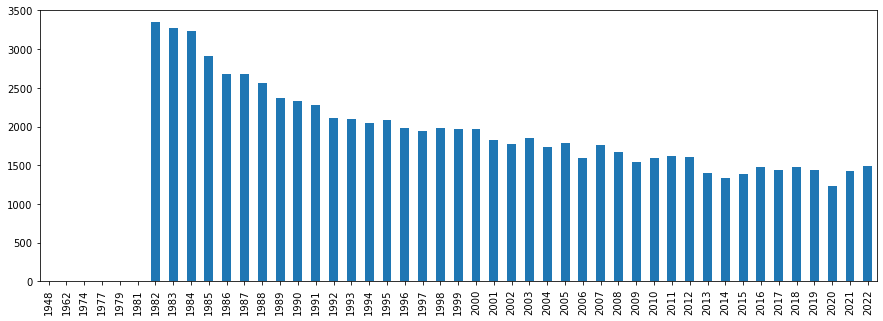

In [4]:
# One interesting thing to note here is the different in the number of entries per year.
# Here it is *before* we filter out non-airplane incidents.
df['Year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

<AxesSubplot:>

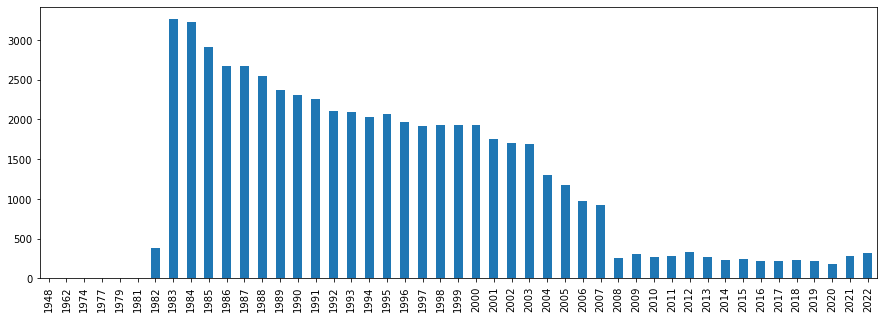

In [5]:
# We can see that the airplane-related incidents and the non-airplane-related incidents are mirror
# images of each other.
df_notplanes = df[df['Aircraft.Category'] != 'airplane']
df_notplanes['Year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

<AxesSubplot:>

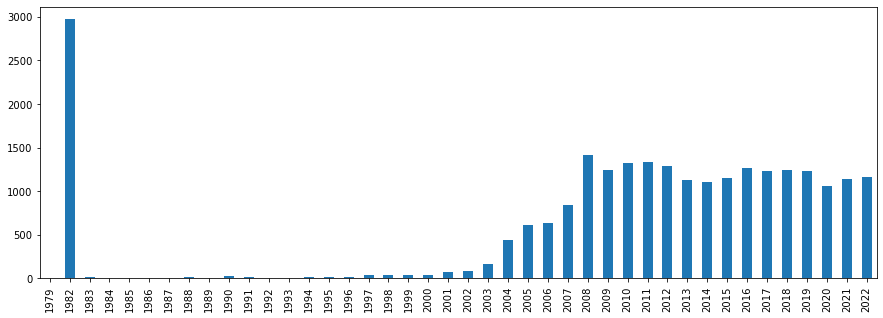

In [6]:
# Filtering out non-airplane incidents
# Keep 'airplane' from the 'Aircraft.Category' column
df = df[df['Aircraft.Category'] == 'airplane']
# And now regraph after the filtering:
df['Year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

# Geographic Filtering

In [7]:
# Only using US incidents
df = df[df['Country'] == 'united states']

# pull state info from locations
df['State'] = df['Location'].str.split(',').str[-1].str.strip().str.upper()
df['State'].value_counts()

CA    2009
TX    1700
AK    1590
FL    1498
AZ     785
CO     643
GA     629
WA     603
IL     490
NY     487
NC     480
MI     467
ID     456
OH     448
OR     434
PA     433
MO     389
AR     375
WI     363
VA     363
MN     356
UT     336
IN     320
NV     316
OK     311
MT     304
KS     304
AL     302
NM     301
NJ     299
TN     294
LA     290
SC     268
MD     235
MA     219
IA     216
MS     203
NE     194
WY     185
KY     165
ND     148
ME     147
SD     129
CT     123
HI      91
WV      89
NH      83
VT      53
PR      48
        43
RI      41
DE      24
OF      13
AO      11
PO       8
DC       6
GU       2
GM       1
VI       1
Name: State, dtype: int64

In [8]:
# Merge state names to abbreviated codes
df = pd.merge(df, state_codes, how='left', left_on='State', right_on='Abbreviation')
df = df.drop(['Abbreviation'], 1)
df = df.rename(columns={'State':'State.Code','US_State':"State.Name"})


# FAR Codes & Purpose of Flight

In [9]:
# Cleaning up the FAR.Description column using a .replace() 
# See here for more info on FAR: 
# https://pilotinstitute.com/part-91-vs-121-vs-135/

df['FAR.Description'] = df['FAR.Description'].replace({
    '091': 'part 91',
    'part 91: general aviation': 'part 91',
    '137': 'part 137',
    '135': 'part 135',
    '121': 'part 121',
    'part 137: agricultural': 'part 137',
    'part 135: air taxi & commuter': 'part 135',
    '129': 'part 129',
    'part 121: air carrier': 'part 121',
    '133': 'part 133',
    'part 129: foreign': 'part 129',
    'part 133: rotorcraft external load': 'part 133',
    'part 133: rotorcraft ext. load': 'part 133',
    '125' : 'part 125',
    'part 125: 20+ pax,6000+ lbs': 'part 125',
    '107': 'part 107',
    '103': 'part 103',
    '437': 'part 437',
    'part91f': 'part 91',
    'part 91 subpart f': 'part 91',
    'part 91f: special flt ops.': 'part 91',
    'part 91 subpart k: fractional': 'part 91',
    '091k': 'part 91',
    'pubu': 'public',
    'public use': 'public',
    'public aircraft': 'public',
    'armed forces': 'armf',
}
)

df['FAR.Description'].value_counts()

part 91     18388
part 137     1099
part 135      756
part 121      632
public        134
part 129       59
nusc           12
unknown        10
nusn           10
part 125        8
unk             7
part 133        2
armf            2
Name: FAR.Description, dtype: int64

In [10]:
df['Purpose.of.Flight'].value_counts()

personal                     13042
instructional                 3059
aerial application            1014
business                       723
unknown                        551
positioning                    337
skydiving                      158
aerial observation             154
ferry                          148
other work use                 142
executive/corporate            138
flight test                    114
banner tow                      89
public aircraft - federal       48
air race show                   39
public aircraft                 38
glider tow                      34
public aircraft - state         24
firefighting                    14
public aircraft - local         12
asho                             5
air race/show                    4
pubs                             3
air drop                         3
Name: Purpose.of.Flight, dtype: int64

In [11]:
#Now grouping the 'Purpose.of.flight' category into more general categories

df['purpose_binned'] = df['Purpose.of.flight'].replace(['public aircraft', 'public aircraft - federal', 'public aircraft - state', 'public aircraft - local', 'public aircraft - u.s. govt.'], 'public')
# Grouping 'aerial application', 'business', 'other work use', 'banner tow', 'skydiving', 'glider tow', 'air drop' into 'business'
df['purpose_binned'] = df['purpose_binned'].replace(['aerial application', 'business', 'other work use', 'banner tow', 'skydiving', 'glider tow', 'air drop'], 'business')
# Grouping 'executive/corporate', 'ferry' into 'small transport'.
df['purpose_binned'] = df['purpose_binned'].replace(['executive/corporate', 'ferry'], 'small transport')
# Adding more into the public category
df['purpose_binned'] = df['purpose_binned'].replace(['pubs', 'public', 'publ', 'firefighting'], 'public')
# Adding 'flight test' to 'instructional
df['purpose_binned'] = df['purpose_binned'].replace(['flight test'], 'instructional')
# Grouping air show categories
df['purpose_binned'] = df['purpose_binned'].replace(['air race show', 'air race/show', 'asho', 'air show'])

df['purpose_binned'].value_counts()

personal              13042
instructional          3173
business               1971
unknown                 551
positioning             337
small transport         286
aerial observation      155
public                  139
Name: purpose_binned, dtype: int64

## Filtering the 'Make' series


In [12]:
# Checking out the raw 'Make' values
df['Make'].value_counts()

cessna                            7697
piper                             4322
beech                             1522
boeing                             456
mooney                             391
                                  ... 
north american/victoria mnt lt       1
williams yakovlev                    1
greene r/greene s                    1
leach michael                        1
indy aircraft ltd                    1
Name: Make, Length: 1015, dtype: int64

In [13]:

# Make a list of all the entries that have "cessna" in them and return their strings in a list
cessna_list = df[df['Make'].str.contains('cessna')]['Make'].unique().tolist()

#Do the same with the other big makes
grumman_list = df[df['Make'].str.contains('grumman')]['Make'].unique().tolist()
dehavilland_list = df[df['Make'].str.contains('havilland')]['Make'].unique().tolist()
cirrus_list = df[df['Make'].str.contains('cirrus')]['Make'].unique().tolist()
piper_list = df[df['Make'].str.contains('piper')]['Make'].unique().tolist()
boeing_list = df[df['Make'].str.contains('boeing')]['Make'].unique().tolist()
mooney_list = df[df['Make'].str.contains('mooney')]['Make'].unique().tolist()
airtractor_list = df[df['Make'].str.contains('air tractor')]['Make'].unique().tolist()

print(cessna_list)
print(grumman_list)
print(dehavilland_list)
print(cirrus_list)
print(piper_list)
print(boeing_list)
print(mooney_list)
print(airtractor_list)

['cessna', 'cessna aircraft co', 'cessna/air repair inc', 'cessna/weaver', 'cessna ector', 'cessna aircraft', 'cessna aircraft co.']
['grumman', 'grumman american', 'grumman-schweizer', 'grumman american avn. corp.', 'grumman american aviation', 'grumman acft eng', 'grumman acft eng cor-schweizer', 'grumman aircraft eng corp', 'grumman american aviation corp', 'grumman aircraft', 'grumman schweizer', 'grumman acft eng cor', 'grumman aircraft cor-schweizer', 'grumman american avn. corp']
['de havilland', 'dehavilland', 'dehavilland canada']
['cirrus design corp.', 'cirrus', 'cirrus design', 'cirrus design corp', 'cirrus design corporation']
['piper', 'piper-aerostar', 'piper aircraft', 'piper/cub crafters', 'piper cub crafters', 'piper aerostar', 'new piper aircraft inc', 'piper aircraft inc', 'jetprop dlx piper', "piper/wally's flyers inc", 'piper aircraft, inc.', 'new piper', 'piper / laudeman', 'piper-harris', 'piper aircraft corporation']
['boeing', 'boeing stearman', 'boeing of can

In [14]:
df['Make'] = df['Make'].replace(cessna_list, 'cessna')
df['Make'] = df['Make'].replace(grumman_list, 'grumman')
df['Make'] = df['Make'].replace(dehavilland_list, 'dehavilland')
df['Make'] = df['Make'].replace(cirrus_list, 'cirrus')
df['Make'] = df['Make'].replace(piper_list, 'piper')
df['Make'] = df['Make'].replace(mooney_list, 'mooney')
df['Make'] = df['Make'].replace(airtractor_list, 'airtractor')

# And we can now see the totals, with slightly different numbers than before.
df['Make'].value_counts()

cessna                            7730
piper                             4368
beech                             1522
boeing                             456
mooney                             437
                                  ... 
hamilton                             1
north american/victoria mnt lt       1
williams yakovlev                    1
greene r/greene s                    1
indy aircraft ltd                    1
Name: Make, Length: 968, dtype: int64

In [15]:
# Making a new df that only accepts the top 25 makes:
top_makes = df['Make'].value_counts().head(25).index.tolist()
top_makes_df = df[df['Make'].isin(top_makes)].copy()
top_makes_df['Make'].value_counts()

cessna                       7730
piper                        4368
beech                        1522
boeing                        456
mooney                        437
airtractor                    414
grumman                       409
cirrus                        330
bellanca                      279
aeronca                       226
maule                         225
dehavilland                   165
champion                      164
luscombe                      162
stinson                       145
north american                114
taylorcraft                   109
aero commander                 95
embraer                        85
airbus                         80
aviat aircraft inc             76
diamond aircraft ind inc       73
aviat                          68
ercoupe                        66
raytheon aircraft company      61
Name: Make, dtype: int64

# Airports

In [16]:
# Clean airport names

df['Airport.Name'] = df['Airport.Name'].replace(['private airstrip', 'private strip', 'pvt'], 'private')
df['Airport.Name'].value_counts()

private                           345
none                               38
merrill field                      34
phoenix deer valley                25
north perry                        23
                                 ... 
california city municipal airp      1
oshkosh                             1
manitou field airport               1
columbia owens downtown airpor      1
gallatin                            1
Name: Airport.Name, Length: 8558, dtype: int64

# Injury Severity

In [17]:
# Looking at the 'Injury.Severity' column
# We see that it tells us how many people died in a given incident
df['Injury.Severity'].value_counts().head(20)

non-fatal    17469
fatal         2442
fatal(1)       308
fatal(2)       221
incident       164
minor          138
serious         95
fatal(3)        75
fatal(4)        60
fatal(5)        22
fatal(6)        14
fatal(7)         9
fatal(8)         7
fatal(10)        4
fatal(12)        3
fatal(14)        1
fatal(11)        1
fatal(16)        1
fatal(13)        1
fatal(9)         1
Name: Injury.Severity, dtype: int64

In [18]:
# Split number from Fatal(#) to count number of fatalities
# Create a new column tracking the number of these fatalities
df['Num.Fatalities'] = df['Injury.Severity'].str.split('(').str[-1]
df['Num.Fatalities'] = df['Num.Fatalities'].str.split(')').str[0]
df['Num.Fatalities'] = pd.to_numeric(df['Num.Fatalities'], errors='coerce').fillna(0).astype(int)
df['Num.Fatalities'].value_counts()

0      20389
1        308
2        221
3         75
4         60
5         22
6         14
7          9
8          7
10         4
12         3
9          1
13         1
228        1
11         1
27         1
65         1
17         1
16         1
14         1
Name: Num.Fatalities, dtype: int64

# Injury Severity

In [19]:
# Update labeling in 'Injury.Severity' column, since we now have a different column that tracks total number of fatalities

df['Injury.Severity'] = df['Injury.Severity'].str.split('(').str[0]
df['Injury.Severity'].value_counts()

non-fatal    17469
fatal         3174
incident       164
minor          138
serious         95
Name: Injury.Severity, dtype: int64

# Damage Severity Score

Making a 'DS.Score' column that takes the 'Aircraft.damage' column and reassigns each category a number:

    - 'destroyed' -> 2
    - 'substantial' -> 1
    - 'minor' -> 0
    
For the time being, 'unknown' is left as such.

In [21]:
# Make a DS.Score based on the 'Aircraft.damage' column

df['DS.Score'] = df['Aircraft.Damage'].replace({
    'destroyed': 2,
    'substantial': 1,
    'minor': 0,
})
df['DS.Score'].value_counts()

1          17817
2           2304
0            481
unknown       40
Name: DS.Score, dtype: int64

# Weather

In [ ]:
# Clean 'Weather.Condition'

df['Weather.Condition'] = df['Weather.Condition'].str.upper()
df['Weather.Condition'].value_counts()

# VMC - Visual Meteorological Conditions - generally clear and good visibility; pilots can navigate and operate aircraft by visual reference to the ground
# IMC - Instrument Meteorological Conditions - reduced visibility due to factors like fog, rain, or low clouds; pilots may need to rely on instruments for navigation and control
# UNK - Unknown

VMC    19278
IMC     1253
UNK      162
Name: Weather.Condition, dtype: int64

# Save cleaned .csv

In [ ]:
#save cleaned df to a new csv file
df.to_csv('../data/AviationData_cleaned.csv', index=False)